# Confidence and Choice (One Layer) Visualizer

Run FF_estimation 10 times (cross-reference runDRAM_twolayer.sh in hydra), then copy all the checkpoints to guppy (cross-reference copyDRAM_classify_blobs_ckpts.sh in hydra and enter password 10x).

Make sure these are the <b>guppy</b> model_settings: <br />
min_edge = 2 <br />
max_edge = 5 <br />
min_blobs = 1 <br />
max_blobs = 15 (15 for training, 9 for testing)<br />
glimpses = max_blobs + 1 <br />
batch_size = 4500

You could then use this entire program or use ClassificationDistributions.ipynb to output confidence_one_run for each run, and set them as the confidence for each run in confidence_all_runs.

Make sure to change the `analysis_estimation_nds.py` file to have the correct neural network graph filename! Then, change the `model_name`, so that the correct model is restored and the data is saved in the correct directory. `iter_list` may need to be changed

In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from analysis_estimation_nds import read_n, classify_imgs, classify_imgs_fh, classify_imgs_lh
import matplotlib.pyplot as plt
%matplotlib inline

['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/classify_log.csv', 'model_runs/-f/classifymodel_0.ckpt', 'model_runs/-f/classifymodel_', 'model_runs/-f/zzzdraw_data_5000.npy', 'false', 'true', 'false', 'false', 'true']
Instructions for updating:
keep_dims is deprecated, use keepdims instead
analysis_onelayer_nds.py


In [2]:
model_name = "New_CAA_decrs_fN"
num_runs = 10
iter_list = [0, 200, 400, 1600, 6400, 25600, 102400, 204800, 409600, 819200, 1000000, 1228800, 1638400, 2000000, 3000000]#, 4000000, 5000000, 6000000]
max_blobs = 15
min_blobs = 1

num_iters = len(iter_list)
output_size = max_blobs - min_blobs + 1 # 15
data_directory = "data/" + model_name + "/"
m = 0.5

confidence_all_runs_fh = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_fh = np.zeros([num_runs, num_iters, output_size, output_size]) 
confidence_all_runs_lh = np.zeros([num_runs, num_iters, output_size, output_size]) 
choice_all_runs_lh = np.zeros([num_runs, num_iters, output_size, output_size]) 
num_iters

import os
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

In [3]:
def fill_matrix_fh(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 9000 # batch_size
    imgs_data = classify_imgs_fh(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size, output_size])
    choice_one_run = np.zeros([output_size, output_size])

    for nb in range(output_size): 
        num_blobs = nb + min_blobs # 1 to 15
        confidence_hist = np.zeros(output_size)
        choice_hist = np.zeros(output_size)
        num_imgs_with_num_blobs = 0.00001

        for idx, data in enumerate(imgs_data):

            if data["label"][nb] == 1: # data is for an image with num_blobs blobs
                num_imgs_with_num_blobs += 1

                # Histogram of softmaxes
                confidence_hist += data["classifications"][0][0]

                # Histogram of choices
                choice = np.argmax(data["classifications"][0][0])
                choice_list = [0] * output_size
                choice_list[choice] = 1
                choice_hist += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()

        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())
    return confidence_one_run, choice_one_run

In [4]:
for run in range(num_runs):
    path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
    for i, iteration in enumerate(iter_list):
        confidence_all_runs_fh[run, i], choice_all_runs_fh[run, i] = fill_matrix_fh(path, iteration)

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_819200.ckpt
INFO:t

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_819200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_1000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_1228800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_1638400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_2000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_3000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run7/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run7/classifymodel_20

In [5]:
def fill_matrix_lh(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = 9000 # batch_size
    imgs_data = classify_imgs_lh(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size, output_size])
    choice_one_run = np.zeros([output_size, output_size])

    for nb in range(output_size): 
        num_blobs = nb + min_blobs # 1 to 15
        confidence_hist = np.zeros(output_size)
        choice_hist = np.zeros(output_size)
        num_imgs_with_num_blobs = 0.00001

        for idx, data in enumerate(imgs_data):

            if data["label"][nb] == 1: # data is for an image with num_blobs blobs
                num_imgs_with_num_blobs += 1

                # Histogram of softmaxes
                confidence_hist += data["classifications"][0][0]

                # Histogram of choices
                choice = np.argmax(data["classifications"][0][0])
                choice_list = [0] * output_size
                choice_list[choice] = 1
                choice_hist += choice_list

        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()

        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
#     print("Confidence (One Run): ",confidence_one_run[nb])
#     print(confidence_one_run.tolist())
#     print("Choice (One Run): ",choice_one_run[nb])
#     print(choice_one_run.tolist())
    return confidence_one_run, choice_one_run

In [6]:
for run in range(num_runs):
    path = 'model_runs/' + model_name + '_run' + str(run + 1) # '/run_' if all the runs are stored in one folder
    for i, iteration in enumerate(iter_list):
        confidence_all_runs_lh[run, i], choice_all_runs_lh[run, i] = fill_matrix_lh(path, iteration)

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_1600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_6400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_25600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_102400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run1/classifymodel_819200.ckpt
INFO:t

INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_204800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_409600.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_819200.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_1000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_1228800.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_1638400.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_2000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run6/classifymodel_3000000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run7/classifymodel_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/New_CAA_decrs_fN_run7/classifymodel_20

In [7]:
def adj_all_runs(all_runs_matrix):
    """Adjust all the matrices so tick marks start with 1."""
    
    new_all_runs_matrix = np.zeros([num_runs, num_iters, output_size + 1, output_size + 1])
    for m, matrix in enumerate(all_runs_matrix):
        for i in range(num_iters):
            new_all_runs_matrix[m, i] = adj_matrix(matrix[i])
    return new_all_runs_matrix


def adj_matrix(matrix):
    """Adjust the matrix so tick marks start with 1."""
    
    a = np.zeros([1, output_size])
    temp = np.vstack((a, matrix))
    b = np.zeros([output_size + 1, 1])
    new_matrix = np.hstack((b, temp))
    return new_matrix

confidence_all_runs_adj_fh = adj_all_runs(confidence_all_runs_fh)
choice_all_runs_adj_fh = adj_all_runs(choice_all_runs_fh)
confidence_all_runs_adj_lh = adj_all_runs(confidence_all_runs_lh)
choice_all_runs_adj_lh = adj_all_runs(choice_all_runs_lh)

In [8]:
confidence_avg_fh = np.mean(confidence_all_runs_adj_fh, axis=0)
choice_avg_fh = np.mean(choice_all_runs_adj_fh, axis=0)
confidence_avg_lh = np.mean(confidence_all_runs_adj_lh, axis=0)
choice_avg_lh = np.mean(choice_all_runs_adj_lh, axis=0)

In [9]:
def plot_confidence_fh(iter_idx, it, run=None):
    """Plot the confidence heatmap."""
    
    if run is None:
        matrix = confidence_avg_fh[iter_idx]
        plot_title = "F500: Confidence after %d Iterations" % (it)

    else:
        matrix = confidence_all_runs_adj_fh[run, iter_idx]
        plot_title = "F500: Confidence at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)


def plot_choice_fh(iter_idx, it, run=None):
    """Plot the choice heatmap."""
    
    if run is None:
        matrix = choice_avg_fh[iter_idx]
        plot_title = "F500: Choice after %d Iterations" % (it)
    else:
        matrix = choice_all_runs_adj_fh[run, iter_idx]
        plot_title = "F500: Choice at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)

def plot_confidence_lh(iter_idx, it, run=None):
    """Plot the confidence heatmap."""
    
    if run is None:
        matrix = confidence_avg_lh[iter_idx]
        plot_title = "L500: Confidence after %d Iterations" % (it)

    else:
        matrix = confidence_all_runs_adj_lh[run, iter_idx]
        plot_title = "L500: Confidence at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)


def plot_choice_lh(iter_idx, it, run=None):
    """Plot the choice heatmap."""
    
    if run is None:
        matrix = choice_avg_lh[iter_idx]
        plot_title = "L500: Choice after %d Iterations" % (it)
    else:
        matrix = choice_all_runs_adj_lh[run, iter_idx]
        plot_title = "L500: Choice at Run %d after %d Iterations" % (run + 1, it)
    plot_heatmap(matrix, plot_title)

def plot_heatmap(matrix, plot_title):
    """Plot heatmap."""
    
    data = [go.Heatmap(
        z=matrix,
        colorscale="Jet"
    )]

    layout = go.Layout(
        title=plot_title,
        yaxis=dict(
#             range=[max_blobs + m, min_blobs - m],
            range=[9 + m, min_blobs - m],
            title="True Class",
            dtick=1,
            tickcolor='#FFF'
        ),
        xaxis=dict(
            range=[min_blobs - m, max_blobs + m],
            title="Predicted Class",
            dtick=1,
            tickcolor='#FFF'
        ),
        width=500,
        height=500,
        plot_bgcolor="#000",
        paper_bgcolor="#000",
        font=dict(
            color="#FFF"
        ),
        titlefont=dict(
            color="#FFF"
        ),
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [10]:
for i, it in enumerate(iter_list):
    plot_confidence_lh(i, it)
    #plot_confidence_lh(i, it)
    #plot_choice_fh(i, it)
    #plot_choice_lh(i, it)

In [11]:
#for i, it in enumerate(iter_list):
    #plot_confidence(i, it)
    #plot_choice_lh(i, it)

In [12]:
np.save(data_directory + "confidence_hist_fh", confidence_all_runs_fh)
np.save(data_directory + "choice_hist_fh", choice_all_runs_fh)
np.save(data_directory + "confidence_hist_lh", confidence_all_runs_lh)
np.save(data_directory + "choice_hist_lh", choice_all_runs_lh)

In [13]:
confidence_hist_fh = np.load(data_directory + "confidence_hist_fh.npy")
choice_hist_fh = np.load(data_directory + "choice_hist_fh.npy")
confidence_hist_lh = np.load(data_directory + "confidence_hist_lh.npy")
choice_hist_lh = np.load(data_directory + "choice_hist_lh.npy")

In [14]:
def get_msdcv(hist_matrix):
    """Get the mean, standard deviation, and coefficient of variation matrices from histogram matrix."""
    
    msdcv = np.zeros([num_runs, num_iters, output_size, 3])
    
    for run in range(num_runs):
        for i, it in enumerate(iter_list):
            for t in range(output_size):
                values_sum = 0
                sqr_sum = 0

                # Find the mean
                for p in range(output_size):
                    values_sum += (p + 1) * hist_matrix[run, i, t, p]
                msdcv[run, i, t, 0] = mu = values_sum

                # Find the standard deviation
                for p in range(output_size):
                    sqr_sum += (p + 1 - mu)**2 * hist_matrix[run, i, t, p]
                msdcv[run, i, t, 1] = sigma = np.sqrt(sqr_sum)

                # Find the coefficient of variation
                msdcv[run, i, t, 2] = cv = sigma / mu
    return msdcv

In [15]:
confidence_msdcv_fh = get_msdcv(confidence_hist_fh)
choice_msdcv_fh = get_msdcv(choice_hist_fh)
confidence_msdcv_lh = get_msdcv(confidence_hist_lh)
choice_msdcv_lh = get_msdcv(choice_hist_lh)

In [16]:
np.save(data_directory + "confidence_msdcv_fh", confidence_msdcv_fh)
np.save(data_directory + "choice_msdcv_fh", choice_msdcv_fh)
np.save(data_directory + "confidence_msdcv_lh", confidence_msdcv_lh)
np.save(data_directory + "choice_msdcv_lh", choice_msdcv_lh)

## Visualize Mean, Standard Deviation, and Coefficient of Variation

In [17]:
# chist = np.load(data_directory + "confidence_hist.npy")
# cm = np.load(data_directory + "confidence_msdv.npy")
chist = np.load(data_directory + "choice_hist_fh.npy") # chist[run, i, output_size, output_size]
cm = np.load(data_directory + "choice_msdcv_fh.npy") # cm[run, i ,t ,3]
cmus = cm[:,:,0:9,0] # mean
csds = cm[:,:,0:9,1] # sd
ccvs = cm[:,:,0:9,2] # cv

In [18]:
chist_mu = np.mean(chist,axis=0)
chist_min = np.min(chist,axis=0)
chist_max = np.max(chist,axis=0)
cmus_mu = np.mean(cmus,axis=0)
cmus_min = np.min(cmus,axis=0)
cmus_max = np.max(cmus,axis=0)
csds_mu = np.mean(csds,axis=0)
csds_min = np.min(csds,axis=0)
csds_max = np.max(csds,axis=0)
ccvs_mu = np.mean(ccvs,axis=0)
ccvs_min = np.min(ccvs,axis=0)
ccvs_max = np.max(ccvs,axis=0)

In [19]:
# baseline
x = [1,2,3,4,5,6,7,8,9]
rf = np.divide(1,np.square(x)) # 1/(x^2)
d = np.sum(rf)
f = np.divide(rf,d)

In [20]:
def plot_hists(i_ind):
    mumat = chist_mu[i_ind,:,0:9]
    minmat = chist_min[i_ind,:,0:9]
    maxmat = chist_max[i_ind,:,0:9]
    fig, ax = plt.subplots(9,1,sharex=True, sharey=True,figsize=(5,10))
    x = [1,2,3,4,5,6,7,8,9]
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    tstr = 'I = ' + str(iter_list[i_ind])
    ax[0].set_title(tstr)
    for i in range(9):
        ax[i].plot(x,mumat[i,:],'k-')
        ax[i].fill_between(x,minmat[i,:],maxmat[i,:], facecolor='orange')
        ax[i].plot(x,f)
    plt.show()

In [21]:
def plot_one_hist(run,i_ind):
    mumat = chist[run-1,i_ind,:,0:9]
    fig, ax = plt.subplots(9,1,sharex=True, sharey=True,figsize=(5,10))
    x = [1,2,3,4,5,6,7,8,9]
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    tstr = 'Run = ' + str(run) + ', Iter = ' + str(iter_list[i_ind])
    ax[0].set_title(tstr)
    for i in range(9):
        ax[i].plot(x,mumat[i,:],'k-')
    plt.show()

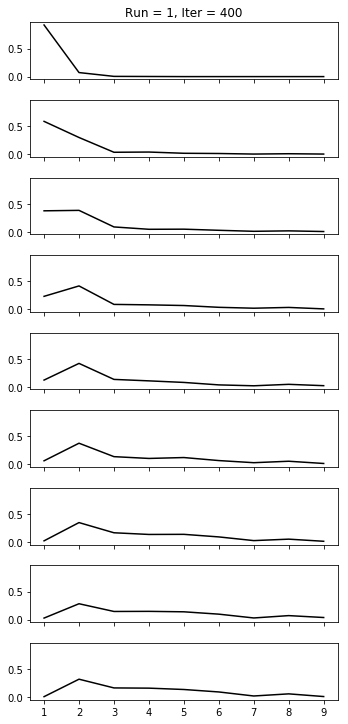

In [22]:
plot_one_hist(1,2) # Run =1, Iter = 1000

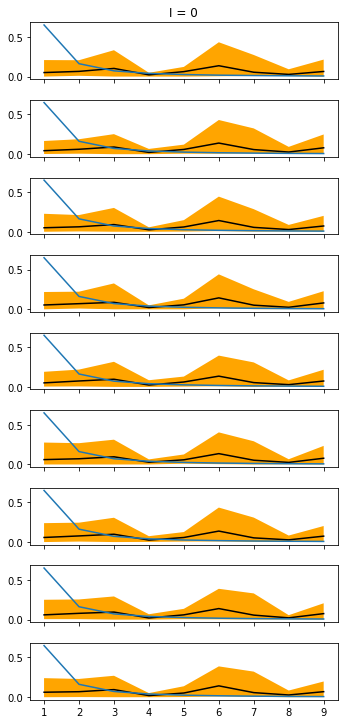

In [23]:
plot_hists(0) # All runs

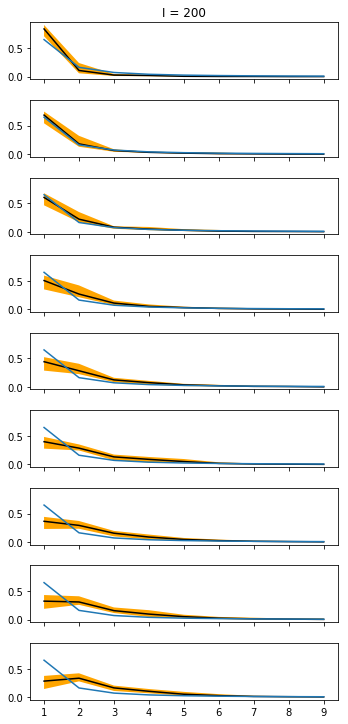

In [24]:
plot_hists(1)

In [25]:
plot_hists(50)

IndexError: index 50 is out of bounds for axis 0 with size 15

In [ ]:
plot_hists(110)

In [ ]:
def plot_stats(smu,smin,smax):
    fig, ax = plt.subplots(num_iters, sharex=True, sharey=True,figsize=(5,70))
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    x = [1,2,3,4,5,6,7,8,9]
    for i in range(num_iters):
        tstr = 'I = ' + str(iter_list[i])
        ax[i].set_title(tstr)
        ax[i].plot(x,smu[i,:],'k-')
        ax[i].fill_between(x,smin[i,:],smax[i,:], facecolor='orange')
    plt.show()

In [ ]:
plot_stats(cmus_mu,cmus_min,cmus_max) # mean

In [ ]:
plot_stats(csds_mu,csds_min,csds_max) # standard deviation

In [ ]:
plot_stats(ccvs_mu,ccvs_min,ccvs_max) # cv

In [ ]:
# choice_avg: [num_iters, output_size, output_size]
choice_hist = np.zeros([num_iters,10])
for i in range (num_iters):
    for j in range(10):
        choice_hist[i,j] = choice_avg[i,j,j]

In [ ]:
def plot_choice_hists():
    fig, ax = plt.subplots(9,1,sharex=True, sharey=True,figsize=(5,10))
    x = [1,2,3,4,5,6,7,8,9]
    fig.tight_layout()
    plt.xticks([1,2,3,4,5,6,7,8,9])
    #tstr = 'I = ' + str(iter_list[i_ind])
    #ax[0].set_title(tstr)
    for i in range(num_iters):
        for j in range(10):
            ax[j].plot(x,choice_hist[i,j],'k-')
    plt.show()

In [ ]:
import numpy as np

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

x = np.linspace(iter_list[0], iter_list[num_iters-1], num_iters)
y = choice_hist[:,5]

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

p = figure(title="Another Legend Example", tools=TOOLS)

p.line(x, choice_hist[:,1], legend="1",line_color="red", line_width=3)
p.line(x, choice_hist[:,2], legend="2", line_color="orange", line_width=3)
p.line(x, choice_hist[:,3], legend="3", line_color="yellow", line_width=3)
p.line(x, choice_hist[:,4], legend="4", line_color="green", line_width=3)
p.line(x, choice_hist[:,5], legend="5", line_color="blue")
p.line(x, choice_hist[:,6], legend="6", line_color="purple", line_width=3)
p.line(x, choice_hist[:,7], legend="7", line_color="olivedrab", line_width=3)
p.line(x, choice_hist[:,8], legend="8", line_color="tomato", line_width=3)
p.line(x, choice_hist[:,9], legend="9", line_color="gold", line_width=3)
p.xaxis.axis_label = "Iterations"
p.yaxis.axis_label = "Ave"
show(gridplot(p, ncols=2, plot_width=800, plot_height=800,title="legend.py example"))  # open a browser